In [13]:
import pandas as pd
import openpyxl
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

In [14]:
# Establish the connection
conn = psycopg2.connect(
    dbname="telecom",
    user="postgres",
    password="1234",
    host="localhost",
    port="5432"
)

# Create a query to fetch only the top 10 rows
query = "SELECT * FROM xdr_data;"

# Load data into a DataFrame
df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Print the DataFrame
print(df)

C:\Users\HP\AppData\Local\Temp\ipykernel_16988\2489690945.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


           Bearer Id            Start  Start ms              End  End ms  \
0       1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1       1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2       1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3       1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4       1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   
...              ...              ...       ...              ...     ...   
149996  7.277826e+18   4/29/2019 7:28     451.0   4/30/2019 6:02   214.0   
149997  7.349883e+18   4/29/2019 7:28     483.0  4/30/2019 10:41   187.0   
149998  1.311448e+19   4/29/2019 7:28     283.0  4/30/2019 10:46   810.0   
149999  1.311448e+19   4/29/2019 7:28     696.0  4/30/2019 10:40   327.0   
150000           NaN             None       NaN             None     NaN   

        Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0       1823652.0  2.08

In [15]:
# 1. Top 10 handsets used by the customers
top_handsets = df['Handset Type'].value_counts().head(10)
print("Top 10 Handsets:")
print(top_handsets)

Top 10 Handsets:
Handset Type
Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: count, dtype: int64


In [16]:
# 2. Top 3 handset manufacturers
top_manufacturers = df['Handset Manufacturer'].value_counts().head(3)
print("\nTop 3 Handset Manufacturers:")
print(top_manufacturers)


Top 3 Handset Manufacturers:
Handset Manufacturer
Apple      59565
Samsung    40839
Huawei     34423
Name: count, dtype: int64


In [17]:
# 3. Top 5 handsets per top 3 manufacturers
top_3_manufacturers = top_manufacturers.index
filtered_df = df[df['Handset Manufacturer'].isin(top_3_manufacturers)]
top_handsets_per_manufacturer = filtered_df.groupby('Handset Manufacturer')['Handset Type'].value_counts().groupby(level=0).head(5)
print("\nTop 5 Handsets per Top 3 Manufacturers:")
print(top_handsets_per_manufacturer)


Top 5 Handsets per Top 3 Manufacturers:
Handset Manufacturer  Handset Type                  
Apple                 Apple iPhone 6S (A1688)            9419
                      Apple iPhone 6 (A1586)             9023
                      Apple iPhone 7 (A1778)             6326
                      Apple iPhone Se (A1723)            5187
                      Apple iPhone 8 (A1905)             4993
Huawei                Huawei B528S-23A                  19752
                      Huawei E5180                       2079
                      Huawei P20 Lite Huawei Nova 3E     2021
                      Huawei P20                         1480
                      Huawei Y6 2018                      997
Samsung               Samsung Galaxy S8 (Sm-G950F)       4520
                      Samsung Galaxy A5 Sm-A520F         3724
                      Samsung Galaxy J5 (Sm-J530)        3696
                      Samsung Galaxy J3 (Sm-J330)        3484
                      Samsung Galaxy S

In [18]:
# Task 1.1: Aggregating User Behavior
# Aggregating data per user
user_behavior = df.groupby('MSISDN/Number').agg(
    number_of_sessions=('Bearer Id', 'count'),
    session_duration=('Dur. (ms)', 'sum'),
    total_dl_data=('Total DL (Bytes)', 'sum'),
    total_ul_data=('Total UL (Bytes)', 'sum')
).reset_index()
print("\nUser Behavior Aggregation:")
print(user_behavior.head())


User Behavior Aggregation:
   MSISDN/Number  number_of_sessions  session_duration  total_dl_data  \
0   3.360100e+10                   1          116720.0   8.426375e+08   
1   3.360100e+10                   1          181230.0   1.207552e+08   
2   3.360100e+10                   1          134969.0   5.566597e+08   
3   3.360101e+10                   1           49878.0   4.019932e+08   
4   3.360101e+10                   2           37104.0   1.363130e+09   

   total_ul_data  
0     36053108.0  
1     36104459.0  
2     39306820.0  
3     20327526.0  
4     94280527.0  


# Task 1.2: Exploratory Data Analysis
# Ensure to handle missing values and outliers before these steps.


In [19]:
#  handling missing values (replacing with mean)
df.fillna(df.mean(numeric_only=True), inplace=True)

In [20]:
#  handling outliers (simple method: replacing extreme values)
for col in ['Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)']:
    df[col] = df[col].clip(lower=df[col].quantile(0.01), upper=df[col].quantile(0.99))

In [21]:
# Compute descriptive statistics
descriptive_stats = df.describe()
print("\nDescriptive Statistics:")
print(descriptive_stats)


Descriptive Statistics:
          Bearer Id       Start ms         End ms      Dur. (ms)  \
count  1.500010e+05  150001.000000  150001.000000  150001.000000   
mean   1.013887e+19     499.188200     498.800880  102909.188269   
std    2.883600e+18     288.610872     288.096693   69464.607034   
min    6.917538e+18       0.000000       0.000000   12472.000000   
25%    7.349883e+18     250.000000     251.000000   57442.000000   
50%    7.349883e+18     499.000000     500.000000   86399.000000   
75%    1.304243e+19     749.000000     750.000000  132430.000000   
max    1.318654e+19     999.000000     999.000000  398786.000000   

               IMSI  MSISDN/Number          IMEI  Avg RTT DL (ms)  \
count  1.500010e+05   1.500010e+05  1.500010e+05    150001.000000   
mean   2.082016e+14   4.188282e+10  4.847455e+13       109.795706   
std    2.144722e+10   2.438731e+12  2.237359e+13       559.342620   
min    2.040471e+14   3.360100e+10  4.400152e+11         0.000000   
25%    2.082014e+

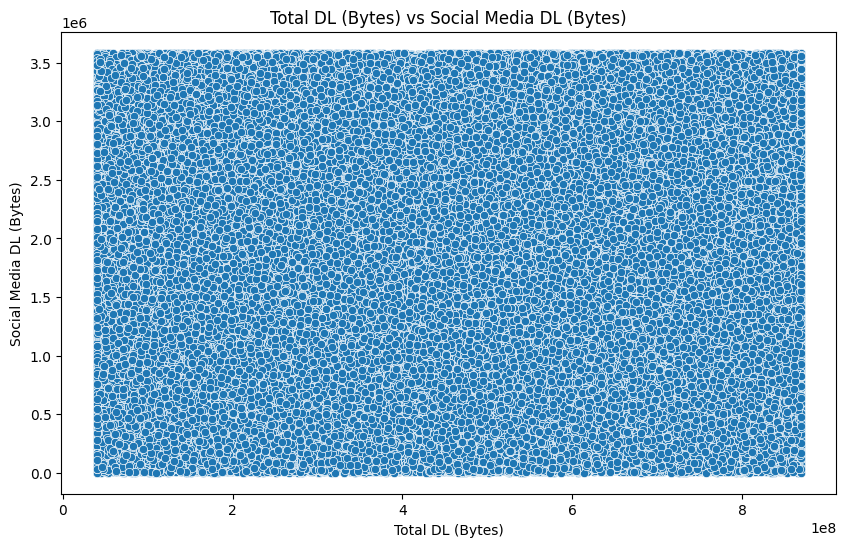

In [22]:
# Bivariate Analysis: Example with Total DL (Bytes) vs. Social Media DL (Bytes)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Total DL (Bytes)', y='Social Media DL (Bytes)')
plt.title('Total DL (Bytes) vs Social Media DL (Bytes)')
plt.xlabel('Total DL (Bytes)')
plt.ylabel('Social Media DL (Bytes)')
plt.show()

In [23]:
# Remove extra spaces from column names
df.columns = df.columns.str.strip()
# Recalculate correlation matrix
correlation_matrix = df[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                         Social Media DL (Bytes)  Google DL (Bytes)  \
Social Media DL (Bytes)                 1.000000          -0.001954   
Google DL (Bytes)                      -0.001954           1.000000   
Email DL (Bytes)                        0.004745          -0.000039   
Youtube DL (Bytes)                     -0.001389           0.001760   
Netflix DL (Bytes)                     -0.001817           0.000548   
Gaming DL (Bytes)                       0.001018          -0.001421   
Other DL (Bytes)                        0.006126          -0.002557   

                         Email DL (Bytes)  Youtube DL (Bytes)  \
Social Media DL (Bytes)          0.004745           -0.001389   
Google DL (Bytes)               -0.000039            0.001760   
Email DL (Bytes)                 1.000000            0.001679   
Youtube DL (Bytes)               0.001679            1.000000   
Netflix DL (Bytes)               0.001351            0.001202   
Gaming DL (Bytes)    

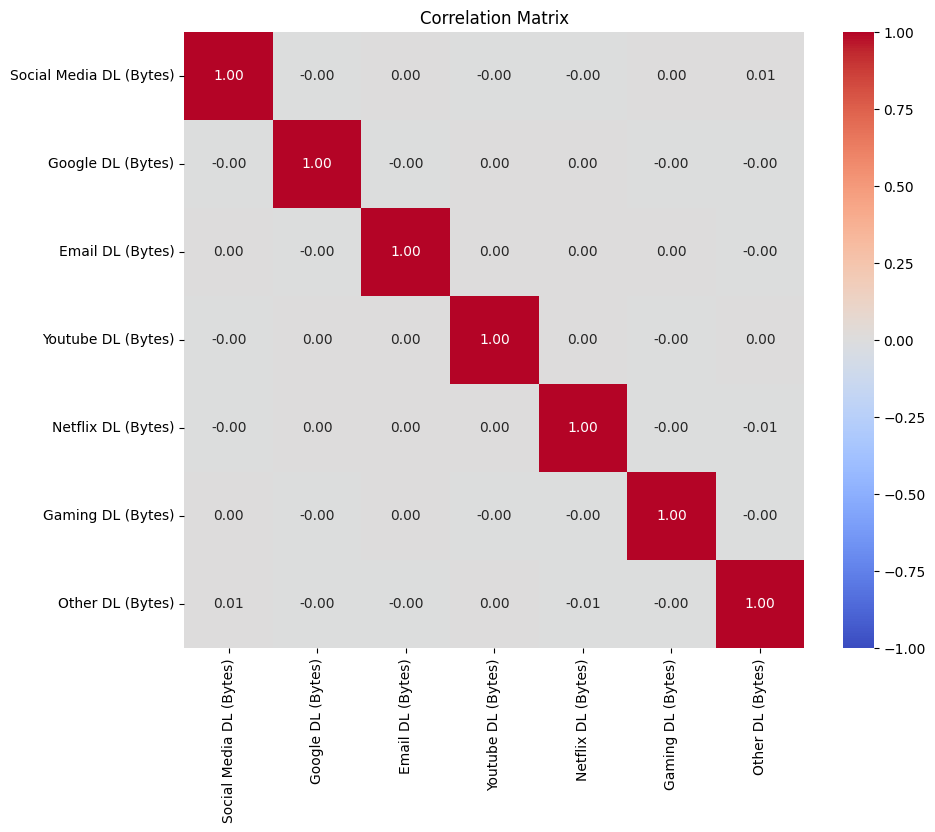

In [24]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
# Set the title and display the plot
plt.title('Correlation Matrix')
plt.show()

In [25]:
# Dimensionality Reduction: Principal Component Analysis (PCA)
# Selecting relevant features for PCA
features = ['Total DL (Bytes)', 'Total UL (Bytes)']
X = df[features].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print("\nPCA Explained Variance Ratio:")
print(pca.explained_variance_ratio_)


PCA Explained Variance Ratio:
[0.99791597 0.00208403]


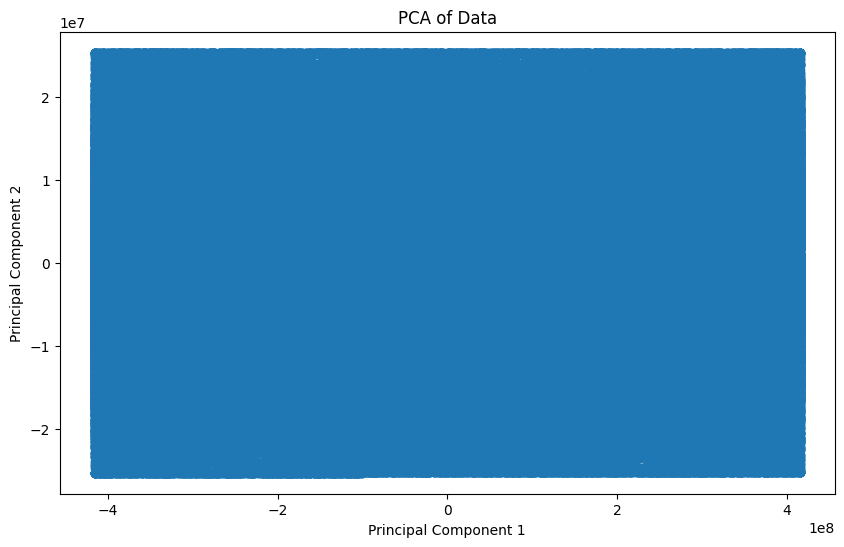

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('PCA of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()